# Analytical analysis on dataset

### Load the images and annotations from dataset

In [2]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from imutils import paths
%matplotlib inline

In [3]:
# Declaring our constants
DATASET_PATH = os.path.join('..','..','Dataset')
DATASET_IMAGE_PATH = os.path.join(DATASET_PATH,'JPGImages')
DATASET_ANNOTATIONS_PATH = os.path.join(DATASET_PATH,'annotations.csv')

In [4]:
# Load images
images = list(paths.list_images(DATASET_IMAGE_PATH))
annotations_df = pd.read_csv(DATASET_ANNOTATIONS_PATH)

In [5]:
print(annotations_df.dtypes)
print('\n[INFO] converting the float64 types to int32 types...\n')
annotations_df = annotations_df.astype({'xmin':'int32', 'xmax':'int32','ymin':'int32','ymax':'int32'})
print(annotations_df.dtypes)

image     object
xmin     float64
ymin     float64
xmax     float64
ymax     float64
label     object
dtype: object

[INFO] converting the float64 types to int32 types...

image    object
xmin      int32
ymin      int32
xmax      int32
ymax      int32
label    object
dtype: object


In [6]:
print(f'[INFO] unique images in \
annotation= {len(annotations_df.image.unique())} \
, images in folder= {len(images)}')
# Removing additional images
print('[INFO] removing additional images...')
images = list(filter(lambda x: os.path.split(x)[1] in annotations_df.image.unique(), images))
print(f'unique images in \
annotation= {len(annotations_df.image.unique())} \
, images in folder= {len(images)}')

[INFO] unique images in annotation= 133 , images in folder= 134
[INFO] removing additional images...
unique images in annotation= 133 , images in folder= 133


In [25]:
classes = list(annotations_df.label.unique())
print(f'[INFO] dataset classes consist of {len(classes)} classes\n \
{classes}')

[INFO] dataset classes consist of 10 classes
 ['Past', 'Gorgonia', 'SeaRods', 'Antillo', 'Fish', 'Ssid', 'Orb', 'Other_Coral', 'Apalm', 'Galaxaura']


### Let's gain a better vision of our classes

In [8]:
class ClassVisualizer:
    def __init__(self, classes, image_per_class, seed):
        self.classes = classes
        self.image_per_class = image_per_class
        self.dictionary = {}
        for c in self.classes:
            np.random.seed(seed)
            rows = annotations_df[annotations_df['label']==c]
            choices = np.random.choice(np.arange(0,len(rows)), size=image_per_class, replace=False)
            self.dictionary[c] = []
            for choice in choices:
                row = rows.iloc[choice]
                image_name = row.image
                image = cv2.imread(os.path.join(DATASET_IMAGE_PATH,image_name))
                self.dictionary[c].append(image[row.ymin:row.ymax, row.xmin:row.xmax, ::-1])
    def get_dict(self):
        return self.dictionary
    def visualize(self):
        fig = plt.figure(constrained_layout=True)
        fig.suptitle(f'{self.image_per_class} Images per {len(self.classes)} Classes',fontsize=25,fontweight='bold')
        subfigs = fig.subfigures(nrows=len(self.classes), ncols=1)
        for row, subfig in enumerate(subfigs):
            c = self.classes[row]
            subfig.suptitle(c,fontsize=15,fontweight='bold')
            axs = subfig.subplots(nrows=1,ncols=self.image_per_class)
            for col, ax in enumerate(axs):
                ax.imshow(self.dictionary[c][col])
                ax.axis('off')
        fig.set_figheight(25)
        return fig


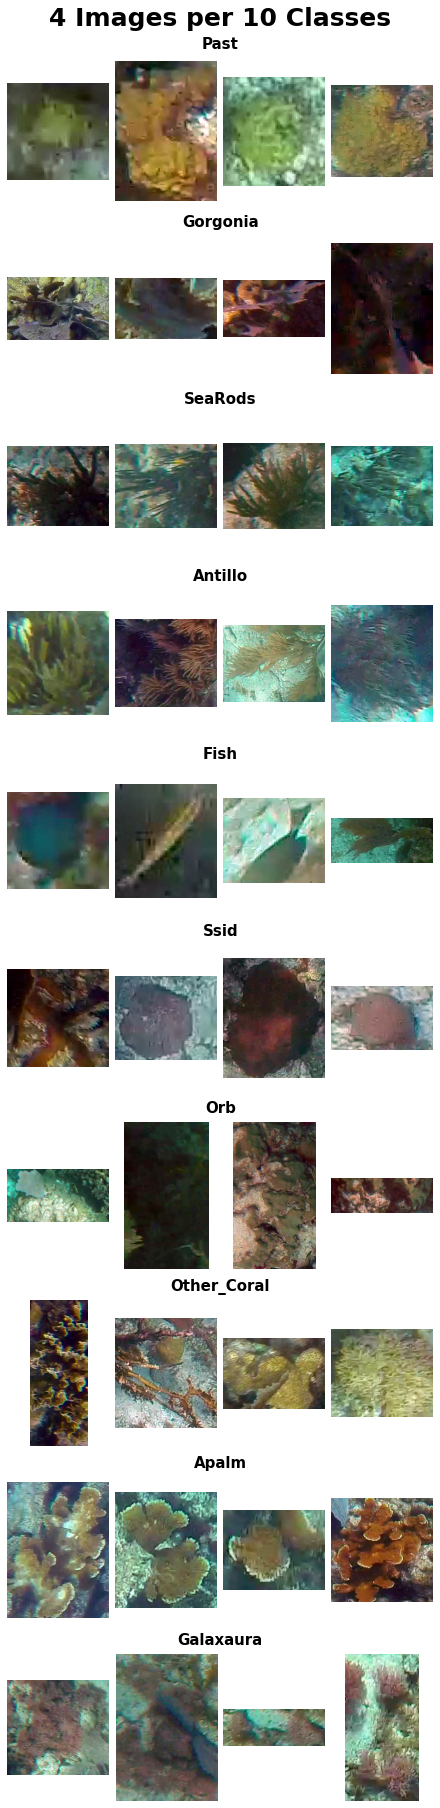

In [9]:
cv = ClassVisualizer(classes, 4, 25)
fig = cv.visualize()

In [10]:
os.makedirs('outputs', exist_ok=True)
fig.savefig(os.path.join('outputs','images_per_class.jpg'),dpi=200)

In [11]:
# Counting number of objects in each class.
classes_count_df = annotations_df[['label','image']].groupby('label').count().rename({'image':'count','label':'class'},axis=1)
classes_count_df.sort_values(by='count',ascending=False,inplace=True)
total_objects = np.sum(classes_count_df['count'].values)
classes_count_df['percentage'] = classes_count_df['count']/total_objects * 100

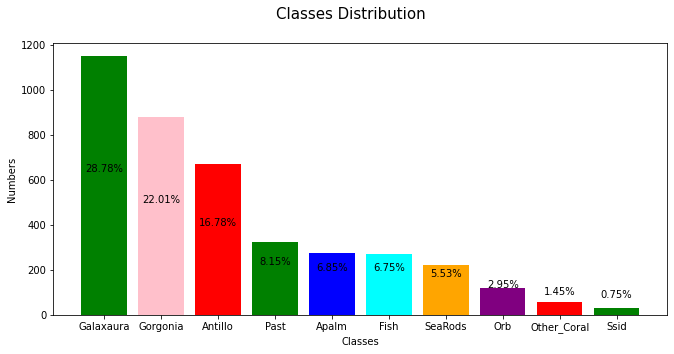

In [12]:
fig = plt.figure(figsize=(11,5))
fig.suptitle('Classes Distribution', fontsize=15)
my_colors = ['green','pink', 'red', 'green', 'blue', 'cyan','orange','purple','red']
graph = plt.bar(classes_count_df['count'].index,classes_count_df['count'].values, color=my_colors)
i=0
for p in graph:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+width/2, y+60+height/2, f'{classes_count_df.percentage[i]:.2f}%', ha='center')
    i+=1
plt.xlabel('Classes')
plt.ylabel('Numbers')
plt.show()
fig.savefig(os.path.join('outputs','classes_distribution.jpg'),dpi=200)

In [42]:
# Inconsistencies with Mahdi's reports on Antillo and Past number of classes
classes_count_df


,count,percentage
label,,
Galaxaura,1151,28.782196
Gorgonia,880,22.005501
Antillo,671,16.779195
Past,326,8.152038
Apalm,274,6.851713
Fish,270,6.751688
SeaRods,221,5.526382
Orb,118,2.950738
Other_Coral,58,1.450363


In [115]:
classes = list(classes_count_df.index.values)
objects_per_image_df = annotations_df[['image','label']].groupby('image').count().rename({'label':'# objects'},axis=1).sort_values(by='# objects',ascending=False)
top_5_images = objects_per_image_df.head(5)
bottom_5_images = objects_per_image_df.tail(5)
objects_per_image_df

,# objects
image,
A_3D_L0646_144.jpg,56
3D_L0622_176.jpg,55
3R010215_829.jpg,54
3D_L0622_139.jpg,53
B_3D_L0647_42.jpg,53
...,...
3D_L0441_87.jpg,8
3D_L0443_36.jpg,5
3D_L0441_41.jpg,4


In [44]:
top_5_images

,# objects
image,
A_3D_L0646_144.jpg,56
3D_L0622_176.jpg,55
3R010215_829.jpg,54
3D_L0622_139.jpg,53
B_3D_L0647_42.jpg,53


In [24]:
bottom_5_images

,# objects
image,
3D_L0441_87.jpg,8
3D_L0443_36.jpg,5
3D_L0441_41.jpg,4
3D_L0453_119.jpg,2
3D_L0457_97.jpg,2


In [144]:
my_colors = ['green','pink', 'red', 'green', 'blue', 'cyan','orange','purple','red']
my_colors = ['40810F','F6BFCB','EF4921','40810F','3365FB','68F7FD','F7A429','833C80','EF4921','40810F']

def hex_to_bgr(h):
    r,g,b = tuple(int(h[i:i+2], 16) for i in (0, 2, 4))
    return (b,g,r)

my_colors = list(map(hex_to_bgr,my_colors))
def annotate_photo(image, annotations):
    image = cv2.imread(os.path.join(DATASET_IMAGE_PATH,image))
    for _,row in annotations.iterrows():
        color = my_colors[classes.index(row['label'])]
        image = cv2.rectangle(image, (row['xmin'],row['ymin']), (row['xmax'],row['ymax']), color, 4 )
        image = cv2.putText(image, row['label'], (row['xmin']-10,row['ymin']-20), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 4, cv2.LINE_AA )
        
    return image

def show_images_and_save(title, top_images, bottom_images):
    fig = plt.figure(constrained_layout = True)
    fig.suptitle(title, fontsize=20, fontweight='bold')
    subfigs = fig.subfigures(nrows=1,ncols=2)
    for col, subfig in enumerate(subfigs):
        if col == 0:
            images = top_images
            subfig.suptitle(f'Top {len(top_images)} images',fontsize=10)
        else:
            subfig.suptitle(f'Bottom {len(bottom_images)} images', fontsize=10)
            images = bottom_images
        axses = subfig.subplots(nrows=len(images), ncols=1)
        for row, ax in enumerate(axses):
            anotated_img = annotate_photo(images[row], annotations_df[annotations_df['image'] == images[row]])
            ax.imshow(anotated_img[:,:,::-1])
            ax.axis('off')
    fig.set_figheight(10)
    fig.savefig(os.path.join('outputs',f'{title}.jpg'), dpi=350,bbox_inches='tight')
    return fig

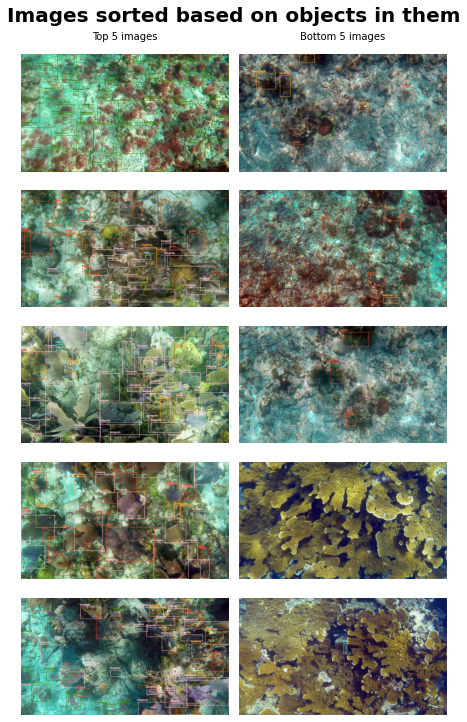

In [145]:
images_sorted_head_and_tail = show_images_and_save('Images sorted based on objects in them',top_5_images.index,bottom_5_images.index)

## Making an overview table 

In [185]:
overview_df = classes_count_df.copy().drop('percentage',axis=1).rename({'count':'# occurrences in dataset'}, axis=1)
overview_df

,# occurrences in dataset
label,
Galaxaura,1151
Gorgonia,880
Antillo,671
Past,326
Apalm,274
Fish,270
SeaRods,221
Orb,118
Other_Coral,58


In [207]:
grouped_by_label_image = annotations_df.groupby(['label','image']).count()
total_images = len(annotations_df.image.unique())
overview_df['Present in % of images'] = [len(grouped_by_label_image.loc[c])/total_images * 100 for c in classes]
overview_df['Average number of class per image'] = overview_df['# occurrences in dataset'] / total_images

annotations_df['area'] = (annotations_df['xmax'] - annotations_df['xmin']) * (annotations_df['ymax'] - annotations_df['ymin'])
overview_df['Average area size in pixles'] = annotations_df[['label','area']].groupby('label').mean()['area']

overview_df

,# occurrences in dataset,Present in % of images,Average number of class per image,Average area size in pixles
label,,,,
Galaxaura,1151,36.090226,8.654135,58328.728931
Gorgonia,880,78.195489,6.616541,65000.598864
Antillo,671,84.210526,5.045113,59240.485842
Past,326,40.601504,2.451128,24664.312883
Apalm,274,21.804511,2.060150,217913.784672
Fish,270,54.887218,2.030075,12805.270370
SeaRods,221,69.924812,1.661654,41415.714932
Orb,118,34.586466,0.887218,323141.093220
Other_Coral,58,18.045113,0.436090,57999.551724
